<a href="https://colab.research.google.com/github/tops201/project_507/blob/main/507_508/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import io

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras

from google.colab import files

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dense, Input, Lambda, LSTM

In [5]:
#fetch dataset

data_file = files.upload() #for google colab

df = pd.read_excel(io.BytesIO(data_file["well3.xlsx"]), index_col="DATEPRD") #for google colab
#df = pd.read_excel("well3.xlsx", index_col="DATEPRD") #for local IDE

date = df.index

df.head()

Saving well3.xlsx to well3.xlsx


,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL
DATEPRD,,,,,,,,,,,
2008-02-12,308.055940,104.418090,201.250000,18.639557,14.484431,106.805939,16.294718,92.475107,284.65,38888.67,385.01
2008-02-13,303.033518,105.402696,182.144942,16.466641,22.832986,120.888576,53.374330,89.620148,1869.70,285246.16,7.13
2008-02-14,295.586061,105.775486,181.867887,12.659589,31.249966,113.718175,72.737631,80.120465,3124.09,509954.88,1.16
2008-02-15,297.662702,105.751875,180.832060,5.264052,28.518930,116.830642,69.995943,84.250990,2608.28,383426.67,0.97
2008-02-16,295.935519,105.811114,180.501045,12.384634,30.227902,115.434474,71.518347,82.359026,3051.80,418474.00,4.89


In [25]:
#function to plot the a series
def plot_series(x, y, format="-", start=None, end=None, label=None):
    plt.plot(x[start:end], y[start:end], format, label=label)
    plt.xlabel("Date")
    plt.ylabel("Oil Volume")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

    
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

#clear session 
def refresh():
  keras.backend.clear_session()
  tf.random.set_seed(42)
  np.random.seed(42)

class ResetStatesCallback(Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

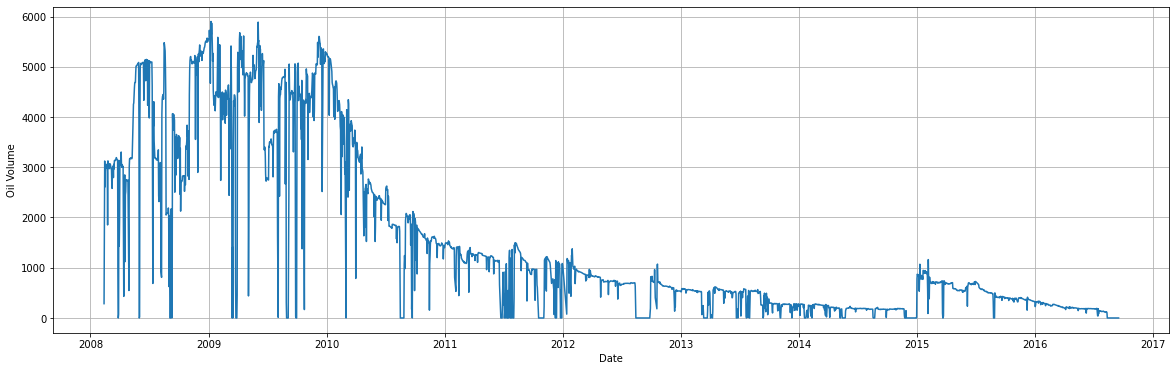

array([ 284.65, 1869.7 , 3124.09, ...,    0.  ,    0.  ,    0.  ])

In [7]:
oil_data = df.BORE_OIL_VOL.to_numpy()

plt.figure(figsize=(20, 6))
plot_series(date, oil_data)
plt.show()

oil_data

In [8]:
#split the time series into training and validation sets
split_date = 2750

date_train = date[:split_date]
date_valid = date[split_date:]

x_train = oil_data[:split_date]
x_valid = oil_data[split_date:]

print(x_train.shape, x_valid.shape, date_train.shape, date_valid.shape)

(2750,) (306,) (2750,) (306,)


# RNN Model - LSTM

In [9]:
refresh()

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = Sequential([
    
        LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(100, return_sequences=True, stateful=True),
        Dense(1)
        #Lambda(lambda x: x * 200.0)
    
    ])

learning_rate_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[learning_rate_schedule, reset_states])

Epoch 1/100
91/91 [==============================] - 4s 14ms/step - loss: 1650.9897 - mae: 1651.4656
Epoch 2/100
91/91 [==============================] - 1s 14ms/step - loss: 1650.9862 - mae: 1651.4637
Epoch 3/100
91/91 [==============================] - 1s 14ms/step - loss: 1650.9840 - mae: 1651.4597
Epoch 4/100
91/91 [==============================] - 1s 14ms/step - loss: 1650.9813 - mae: 1651.4573
Epoch 5/100
91/91 [==============================] - 1s 14ms/step - loss: 1650.9788 - mae: 1651.4546
Epoch 6/100
91/91 [==============================] - 1s 14ms/step - loss: 1650.9760 - mae: 1651.4518
Epoch 7/100
91/91 [==============================] - 1s 14ms/step - loss: 1650.9733 - mae: 1651.4495
Epoch 8/100
91/91 [==============================] - 1s 14ms/step - loss: 1650.9706 - mae: 1651.4459
Epoch 9/100
91/91 [==============================] - 1s 14ms/step - loss: 1650.9683 - mae: 1651.4443
Epoch 10/100
91/91 [==============================] - 1s 14ms/step - loss: 1650.9657 - mae:

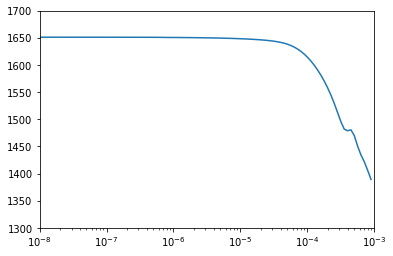

1389.3135986328125

In [23]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 1300, 1700])
plt.show()

min(history.history["loss"])

In [28]:
refresh()

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = Sequential([
                    
        LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(100, return_sequences=True, stateful=True),
        Dense(1),
        #Lambda(lambda x: x * 200.0)
        
        ])

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

reset_states = ResetStatesCallback()
model_checkpoint = ModelCheckpoint("my_checkpoint.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=50)

model.fit(train_set, epochs=500, validation_data=valid_set, 
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
91/91 [==============================] - 5s 22ms/step - loss: 1650.7976 - mae: 1651.2678 - val_loss: 211.7826 - val_mae: 212.2350
Epoch 2/500
91/91 [==============================] - 1s 14ms/step - loss: 1650.2924 - mae: 1650.7756 - val_loss: 211.3517 - val_mae: 211.8172
Epoch 3/500
91/91 [==============================] - 1s 15ms/step - loss: 1649.9385 - mae: 1650.4302 - val_loss: 211.0211 - val_mae: 211.4965
Epoch 4/500
91/91 [==============================] - 1s 14ms/step - loss: 1649.6221 - mae: 1650.1168 - val_loss: 210.7117 - val_mae: 211.1938
Epoch 5/500
91/91 [==============================] - 1s 14ms/step - loss: 1649.3231 - mae: 1649.8185 - val_loss: 210.4261 - val_mae: 210.9128
Epoch 6/500
91/91 [==============================] - 1s 15ms/step - loss: 1649.0404 - mae: 1649.5376 - val_loss: 210.1543 - val_mae: 210.6441
Epoch 7/500
91/91 [==============================] - 1s 14ms/step - loss: 1648.7684 - mae: 1649.2645 - val_loss: 209.8997 - val_mae: 210.3918
Epoch 

In [29]:
#load best model
model = keras.models.load_model("my_checkpoint.h5")

In [32]:
#forcast
rnn_forecast = model.predict(oil_data[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_date - 1:-1, 0]

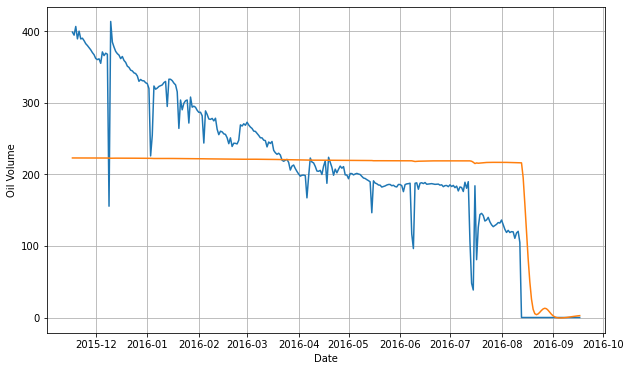

In [33]:
plt.figure(figsize=(10, 6))
plot_series(date_valid, x_valid)
plot_series(date_valid, rnn_forecast)

In [34]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

57.93529

#univariate

In [ ]:
# specify the window size
n_steps = 7

# split into samples
X, y = split_sequence(values, n_steps)

# reshape into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# define model
model = Sequential()

model.add(Input(shape=(X_train.shape[1],)))

In [ ]:
model.add(LSTM(100, activation='relu', kernel_initializer='he_normal'))

In [ ]:
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# fit the model
model.fit(X_train, y_train, epochs=350, batch_size=32, verbose=2, validation_data=(X_test, y_test))

# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, sqrt(mse), mae))

# make a prediction


In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

#  MLP

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# determine the number of input & output features
features_in = X_train.shape[1]
features_out = y_train.shape[1]

# define model
mlp = Sequential()

mlp.add(Input(shape=(features_in,)))

mlp.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
mlp.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
mlp.add(Dense(features_out))

# compile the model
mlp.compile(optimizer='adam', loss='mse')

# fit the model
mlp.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)

# evaluate the model
error = mlp.evaluate(X_test, y_test, verbose=2)
print('MSE: %.3f, RMSE: %.3f' % (error, sqrt(error)))
